<a href="https://colab.research.google.com/github/DatawizThailand/datawiz-tutorial/blob/master/Stock_forecast_LSTM_Pytorch_change.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Load and preprocess data**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))
pd.options.display.max_columns = 999
pd.options.display.max_rows = 999

!pip install pandas_datareader
from pandas_datareader import data as pdr
from tqdm import tqdm_notebook

stock_list = ['KBANK','SCB','BBL','KTB']
stock_data = []
stock_name = []
for quote in tqdm_notebook(stock_list):
    try:
        stock_data.append(pdr.get_data_yahoo(f'{quote}.BK', start='1990-01-01', end='2019-04-15'))
        stock_name.append(quote)
    except:
        print("Error:", sys.exc_info()[0])
        print("Description:", sys.exc_info()[1])

In [2]:
stock_data[0].head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2000-01-04,44.75,44.0,44.25,44.50,10659200.0,32.016865
2000-01-05,43.00,41.5,42.25,41.75,16305600.0,30.038294
2000-01-06,42.00,40.5,42.00,40.75,8241300.0,29.318813
2000-01-07,43.00,41.0,41.25,42.75,6058600.0,30.757778
2000-01-10,44.25,42.5,43.75,42.75,7774300.0,30.757778


In [0]:
# function สำหรับ preprocess ข้อมูล time series หลายตัวแปร
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True,feat_name=None):
    
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [f'{feat_name[j]}(t-{i})' for j in range(n_vars)]
    
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [f'{feat_name[j]}(t)' for j in range(n_vars)]
        else:
            names += [f'{feat_name[j]}(t+{i})' for j in range(n_vars)]
    
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

# เลือกข้อมูลหุ้นจาก list ของ DataFrame และ drop column 'Close' เนื่องจากเราจะใช้ column 'Adj. Close' เท่านั้น
dataset = stock_data[0]
dataset = dataset.drop('Close',axis=1)
dataset['pct_change'] = dataset['Adj Close'].pct_change().dropna()
values = dataset.values
values = values.astype('float32')

# ทำ scaling ข้อมูลด้วยวิธี min max scaling เปลี่ยน scale ข้อมูลแต่ละ column ให้อยู่ระหว่าง [0,1] และเก็บค่า min max แต่ละ column ไว้สำหรับทำ rescale ข้อมูลภายหลัง
min_dict = dict()
max_dict = dict()
for col in dataset.columns:
  min_dict[col] = dataset[col].min()
  max_dict[col] = dataset[col].max()
  dataset[col] = (dataset[col] - dataset[col].min())/(dataset[col].max()-dataset[col].min())
  
# ใช้ function สำหรับ preprocess ข้อมูลที่เขียนไว้ และ drop column ที่ไม่ได้ใช้
reframed = series_to_supervised(dataset.values, 60, 1,feat_name=dataset.columns)
reframed.drop(['High(t)','Low(t)','Open(t)','Volume(t)','Adj Close(t)'],
              axis=1,inplace=True)

In [4]:
reframed.head(10)

,High(t-60),Low(t-60),Open(t-60),Volume(t-60),Adj Close(t-60),pct_change(t-60),High(t-59),Low(t-59),Open(t-59),Volume(t-59),Adj Close(t-59),pct_change(t-59),High(t-58),Low(t-58),Open(t-58),Volume(t-58),Adj Close(t-58),pct_change(t-58),High(t-57),Low(t-57),Open(t-57),Volume(t-57),Adj Close(t-57),pct_change(t-57),High(t-56),Low(t-56),Open(t-56),Volume(t-56),Adj Close(t-56),pct_change(t-56),High(t-55),Low(t-55),Open(t-55),Volume(t-55),Adj Close(t-55),pct_change(t-55),High(t-54),Low(t-54),Open(t-54),Volume(t-54),Adj Close(t-54),pct_change(t-54),High(t-53),Low(t-53),Open(t-53),Volume(t-53),Adj Close(t-53),pct_change(t-53),High(t-52),Low(t-52),Open(t-52),Volume(t-52),Adj Close(t-52),pct_change(t-52),High(t-51),Low(t-51),Open(t-51),Volume(t-51),Adj Close(t-51),pct_change(t-51),High(t-50),Low(t-50),Open(t-50),Volume(t-50),Adj Close(t-50),pct_change(t-50),High(t-49),Low(t-49),Open(t-49),Volume(t-49),Adj Close(t-49),pct_change(t-49),High(t-48),Low(t-48),Open(t-48),Volume(t-48),Adj Close(t-48),pct_change(t-48),High(t-47),Low(t-47),Open(t-47),Volume(t-47),Adj Close(t-47),pct_change(t-47),High(t-46),Low(t-46),Open(t-46),Volume(t-46),Adj Close(t-46),pct_change(t-46),High(t-45),Low(t-45),Open(t-45),Volume(t-45),Adj Close(t-45),pct_change(t-45),High(t-44),Low(t-44),Open(t-44),Volume(t-44),Adj Close(t-44),pct_change(t-44),High(t-43),Low(t-43),Open(t-43),Volume(t-43),Adj Close(t-43),pct_change(t-43),High(t-42),Low(t-42),Open(t-42),Volume(t-42),Adj Close(t-42),pct_change(t-42),High(t-41),Low(t-41),Open(t-41),Volume(t-41),Adj Close(t-41),pct_change(t-41),High(t-40),Low(t-40),Open(t-40),Volume(t-40),Adj Close(t-40),pct_change(t-40),High(t-39),Low(t-39),Open(t-39),Volume(t-39),Adj Close(t-39),pct_change(t-39),High(t-38),Low(t-38),Open(t-38),Volume(t-38),Adj Close(t-38),pct_change(t-38),High(t-37),Low(t-37),Open(t-37),Volume(t-37),Adj Close(t-37),pct_change(t-37),High(t-36),Low(t-36),Open(t-36),Volume(t-36),Adj Close(t-36),pct_change(t-36),High(t-35),Low(t-35),Open(t-35),Volume(t-35),Adj Close(t-35),pct_change(t-35),High(t-34),Low(t-34),Open(t-34),Volume(t-34),Adj Close(t-34),pct_change(t-34),High(t-33),Low(t-33),Open(t-33),Volume(t-33),Adj Close(t-33),pct_change(t-33),High(t-32),Low(t-32),Open(t-32),Volume(t-32),Adj Close(t-32),pct_change(t-32),High(t-31),Low(t-31),Open(t-31),Volume(t-31),Adj Close(t-31),pct_change(t-31),High(t-30),Low(t-30),Open(t-30),Volume(t-30),Adj Close(t-30),pct_change(t-30),High(t-29),Low(t-29),Open(t-29),Volume(t-29),Adj Close(t-29),pct_change(t-29),High(t-28),Low(t-28),Open(t-28),Volume(t-28),Adj Close(t-28),pct_change(t-28),High(t-27),Low(t-27),Open(t-27),Volume(t-27),Adj Close(t-27),pct_change(t-27),High(t-26),Low(t-26),Open(t-26),Volume(t-26),Adj Close(t-26),pct_change(t-26),High(t-25),Low(t-25),Open(t-25),Volume(t-25),Adj Close(t-25),pct_change(t-25),High(t-24),Low(t-24),Open(t-24),Volume(t-24),Adj Close(t-24),pct_change(t-24),High(t-23),Low(t-23),Open(t-23),Volume(t-23),Adj Close(t-23),pct_change(t-23),High(t-22),Low(t-22),Open(t-22),Volume(t-22),Adj Close(t-22),pct_change(t-22),High(t-21),Low(t-21),Open(t-21),Volume(t-21),Adj Close(t-21),pct_change(t-21),High(t-20),Low(t-20),Open(t-20),Volume(t-20),Adj Close(t-20),pct_change(t-20),High(t-19),Low(t-19),Open(t-19),Volume(t-19),Adj Close(t-19),pct_change(t-19),High(t-18),Low(t-18),Open(t-18),Volume(t-18),Adj Close(t-18),pct_change(t-18),High(t-17),Low(t-17),Open(t-17),Volume(t-17),Adj Close(t-17),pct_change(t-17),High(t-16),Low(t-16),Open(t-16),Volume(t-16),Adj Close(t-16),pct_change(t-16),High(t-15),Low(t-15),Open(t-15),Volume(t-15),Adj Close(t-15),pct_change(t-15),High(t-14),Low(t-14),Open(t-14),Volume(t-14),Adj Close(t-14),pct_change(t-14),High(t-13),Low(t-13),Open(t-13),Volume(t-13),Adj Close(t-13),pct_change(t-13),High(t-12),Low(t-12),Open(t-12),Volume(t-12),Adj Close(t-12),pct_change(t-12),High(t-11),Low(t-11),Open(t-11),Volume(t-11),Adj Close(t-11),pct_change(t-11),High(t-10),Low(t-10),Open(t-10),Volume(t-10),Adj Close(t-10),pct_change(t-10),High(t-9),Low(t-9),Op

In [0]:
# split into train and test sets
n_train_percent = 0.9
split = int(reframed.shape[0]*n_train_percent)
df_seq_train = reframed.iloc[:split, :]
df_seq_test = reframed.iloc[split:, :]

date_all = dataset.index[reframed.index]

## Extract features from datetime

In [0]:
df_dt = pd.DataFrame({'date_time':date_all})

In [0]:
df_dt_feat = pd.concat([df_dt.date_time.dt.day, df_dt.date_time.dt.dayofweek, df_dt.date_time.dt.dayofyear,\
                           df_dt.date_time.dt.daysinmonth, df_dt.date_time.dt.is_month_end,df_dt.date_time.dt.is_month_start,\
                           df_dt.date_time.dt.is_quarter_end, df_dt.date_time.dt.is_quarter_start, df_dt.date_time.dt.is_year_end,\
                           df_dt.date_time.dt.is_year_start],axis=1)
df_dt_feat.columns = ['day','dayofweek','dayofyear','daysinmonth','is_month_end','is_month_start','is_quarter_end','is_quarter_start',\
                        'is_year_end','is_year_start']

In [0]:
df_dt_feat['is_month_end'] = df_dt_feat['is_month_end'].astype(int)
df_dt_feat['is_month_start'] = df_dt_feat['is_month_start'].astype(int)
df_dt_feat['is_quarter_end'] = df_dt_feat['is_quarter_end'].astype(int)
df_dt_feat['is_quarter_start'] = df_dt_feat['is_quarter_start'].astype(int)
df_dt_feat['is_year_end'] = df_dt_feat['is_year_end'].astype(int)
df_dt_feat['is_year_start'] = df_dt_feat['is_year_start'].astype(int)

In [0]:
# encode categorical columns
for col in ['day','dayofweek','dayofyear','daysinmonth']:
  df_dt_feat[col] = df_dt_feat[col].astype('category').cat.as_ordered().cat.codes

In [10]:
df_dt_feat.head()

,day,dayofweek,dayofyear,daysinmonth,is_month_end,is_month_start,is_quarter_end,is_quarter_start,is_year_end,is_year_start
0,28,2,88,3,0,0,0,0,0,0
1,29,3,89,3,0,0,0,0,0,0
2,30,4,90,3,1,0,1,0,0,0
3,2,0,93,2,0,0,0,0,0,0
4,3,1,94,2,0,0,0,0,0,0


In [0]:
df_dt_feat_train = df_dt_feat.iloc[:split]
df_dt_feat_test = df_dt_feat.iloc[split:]

# Dataset & Dataloader



In [0]:
#torch 
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [13]:
device

device(type='cuda', index=0)

In [0]:
class StockDataset(Dataset):
  def __init__(self, df_seq, feat_num, seq_len, target_len, df_cat):
    # SEQUENTIAL PART
    self.df_seq = df_seq.iloc[:,:-target_len]
    self.df_cat = df_cat
    self.target = df_seq.iloc[:,-target_len:]
    
  def __getitem__(self, index):
    return(torch.tensor(self.df_seq.iloc[index].values.reshape(seq_len,feat_num), dtype=torch.float, device=device),
           torch.tensor(self.df_cat.iloc[index], dtype=torch.long, device=device),
           torch.tensor(self.target.iloc[index], dtype=torch.float, device=device))
  
  def __len__(self):
    return(self.df_seq.shape[0])
  
feat_num = 6
seq_len = 60
target_len = 1

bs = 64
train_ds = StockDataset(df_seq_train, feat_num, seq_len, target_len, df_dt_feat_train)
train_dl = DataLoader(train_ds, batch_size=bs, shuffle=False)
test_ds = StockDataset(df_seq_test, feat_num, seq_len, target_len, df_dt_feat_test)
test_dl = DataLoader(test_ds, batch_size=len(test_ds), shuffle=False)

In [15]:
next(iter(train_dl))[0]

tensor([[[0.1209, 0.1180, 0.1192, 0.3240, 0.0896, 0.4005],
         [0.1167, 0.1137, 0.1181, 0.1638, 0.0864, 0.5241],
         [0.1209, 0.1158, 0.1150, 0.1204, 0.0929, 0.7627],
         ...,
         [0.0883, 0.0861, 0.0854, 0.0401, 0.0654, 0.6264],
         [0.0894, 0.0871, 0.0854, 0.0316, 0.0678, 0.6739],
         [0.0925, 0.0903, 0.0886, 0.0570, 0.0719, 0.7190]],

        [[0.1167, 0.1137, 0.1181, 0.1638, 0.0864, 0.5241],
         [0.1209, 0.1158, 0.1150, 0.1204, 0.0929, 0.7627],
         [0.1262, 0.1222, 0.1255, 0.1545, 0.0929, 0.6023],
         ...,
         [0.0894, 0.0871, 0.0854, 0.0316, 0.0678, 0.6739],
         [0.0925, 0.0903, 0.0886, 0.0570, 0.0719, 0.7190],
         [0.0967, 0.0946, 0.0970, 0.0894, 0.0711, 0.5798]],

        [[0.1209, 0.1158, 0.1150, 0.1204, 0.0929, 0.7627],
         [0.1262, 0.1222, 0.1255, 0.1545, 0.0929, 0.6023],
         [0.1230, 0.1201, 0.1224, 0.0842, 0.0904, 0.5450],
         ...,
         [0.0925, 0.0903, 0.0886, 0.0570, 0.0719, 0.7190],
         [

In [16]:
next(iter(train_dl))[1]

tensor([[ 28,   2,  88,   3,   0,   0,   0,   0,   0,   0],
        [ 29,   3,  89,   3,   0,   0,   0,   0,   0,   0],
        [ 30,   4,  90,   3,   1,   0,   1,   0,   0,   0],
        [  2,   0,  93,   2,   0,   0,   0,   0,   0,   0],
        [  3,   1,  94,   2,   0,   0,   0,   0,   0,   0],
        [  4,   2,  95,   2,   0,   0,   0,   0,   0,   0],
        [  5,   3,  96,   2,   0,   0,   0,   0,   0,   0],
        [  6,   4,  97,   2,   0,   0,   0,   0,   0,   0],
        [  9,   0, 100,   2,   0,   0,   0,   0,   0,   0],
        [ 10,   1, 101,   2,   0,   0,   0,   0,   0,   0],
        [ 11,   2, 102,   2,   0,   0,   0,   0,   0,   0],
        [ 12,   3, 103,   2,   0,   0,   0,   0,   0,   0],
        [ 13,   4, 104,   2,   0,   0,   0,   0,   0,   0],
        [ 16,   0, 107,   2,   0,   0,   0,   0,   0,   0],
        [ 17,   1, 108,   2,   0,   0,   0,   0,   0,   0],
        [ 18,   2, 109,   2,   0,   0,   0,   0,   0,   0],
        [ 19,   3, 110,   2,   0,   0,  

In [17]:
next(iter(train_dl))[2]

tensor([[0.5798],
        [0.4662],
        [0.5787],
        [0.6023],
        [0.5070],
        [0.7006],
        [0.6023],
        [0.6739],
        [0.6023],
        [0.6023],
        [0.6490],
        [0.6023],
        [0.6023],
        [0.3953],
        [0.6023],
        [0.6269],
        [0.6023],
        [0.6511],
        [0.6264],
        [0.5785],
        [0.5543],
        [0.6511],
        [0.5543],
        [0.6023],
        [0.5780],
        [0.5532],
        [0.6023],
        [0.6023],
        [0.5275],
        [0.6023],
        [0.3471],
        [0.5747],
        [0.6023],
        [0.4907],
        [0.7469],
        [0.6023],
        [0.4362],
        [0.6607],
        [0.5164],
        [0.5141],
        [0.4511],
        [0.5072],
        [0.6677],
        [0.5383],
        [0.6023],
        [0.8637],
        [0.6931],
        [0.7789],
        [0.7419],
        [0.5488],
        [0.5751],
        [0.6298],
        [0.5207],
        [0.6023],
        [0.5186],
        [0

In [18]:
print(next(iter(train_dl))[0].shape)
print(next(iter(train_dl))[1].shape)
print(next(iter(train_dl))[2].shape)

torch.Size([64, 60, 6])
torch.Size([64, 10])
torch.Size([64, 1])


# **Architecture**

In [0]:
config = {'rnn_p':0., 'rnn_l':1, 'rnn_h':1000, 'seq_len':seq_len, 'rnn_input_dim':feat_num,
          'fc_szs':[1000, 500],'fc_ps':[0.5, 0.25], 'out_sz':target_len,
          'emb_p':0.05}
cat_dict = {'day':31,'dayofweek':5,'dayofyear':366,'daysinmonth':4,'is_month_end':2,
            'is_month_start':2,'is_quarter_end':2,'is_quarter_start':2,'is_year_end':2,'is_year_start':2}
  
# lazy embedding size rule!
def emb_sz_rule(n_cat): return min(50,n_cat)

class StockPredictor(nn.Module):
  def __init__(self,config,cat_size):
    super(StockPredictor, self).__init__()
    # set parameters
    self.rnn_p = config['rnn_p']
    self.rnn_l = config['rnn_l']
    self.rnn_h = config['rnn_h']
    self.seq_len = config['seq_len']
    self.fc_szs = config['fc_szs']
    self.fc_ps = config['fc_ps']
    self.out_sz = config['out_sz']
    self.cat_size = cat_size
    self.emb_p  = config['emb_p']
    
    # embedding layers for categorical features
    self.emb_drop = nn.Dropout(self.emb_p)
    self.cat_layers = nn.ModuleList([nn.Embedding(val,emb_sz_rule(val)) for val in cat_size.values()])
    self.lin_in = sum([emb_sz_rule(val) for val in cat_size.values()]) + self.rnn_h*self.seq_len
    self.fc_szs = [self.lin_in] + self.fc_szs
    
    # recurrent layers
    self.rnn_layers = nn.LSTM(config['rnn_input_dim'], self.rnn_h, num_layers=self.rnn_l,
                             bias=True, batch_first=True, dropout=self.rnn_p)
    
    # fully connected layers
    fc_layers_list = []
    for ni, nf, p in zip(self.fc_szs[:-1], self.fc_szs[1:], self.fc_ps):
      fc_layers_list.append(nn.Linear(ni, nf))
      fc_layers_list.append(nn.ReLU(inplace=True))
      fc_layers_list.append(nn.BatchNorm1d(nf))
      fc_layers_list.append(nn.Dropout(p=p))
    self.fc_layers = nn.Sequential(*fc_layers_list)
    
    # output
    self.out = torch.nn.Linear(in_features=self.fc_szs[-1], out_features=self.out_sz)
    
  def forward(self, seq_input, cat_input):
    # cat
    cat_list = [e(cat_input[:,i]) for i,e in enumerate(self.cat_layers)]
    cat_out = torch.cat(cat_list,1)
    cat_out = self.emb_drop(cat_out)
    
    # seq
    bs = seq_input.shape[0]
    seq_out, seq_h = self.rnn_layers(seq_input)
    seq_out = seq_out.contiguous()
    seq_out = seq_out.view(bs,-1)
    
    #linear
    lin_in = torch.cat([cat_out, seq_out],1)
    res = self.fc_layers(lin_in)
    res = self.out(res)
    
    return res

In [20]:
model = StockPredictor(config,cat_dict).to(device)
x = next(iter(train_dl))
seq_input = x[0]
cat_input = x[1]
model(seq_input, cat_input).shape

torch.Size([64, 1])

In [21]:
model

StockPredictor(
  (emb_drop): Dropout(p=0.05)
  (cat_layers): ModuleList(
    (0): Embedding(31, 31)
    (1): Embedding(5, 5)
    (2): Embedding(366, 50)
    (3): Embedding(4, 4)
    (4): Embedding(2, 2)
    (5): Embedding(2, 2)
    (6): Embedding(2, 2)
    (7): Embedding(2, 2)
    (8): Embedding(2, 2)
    (9): Embedding(2, 2)
  )
  (rnn_layers): LSTM(6, 1000, batch_first=True)
  (fc_layers): Sequential(
    (0): Linear(in_features=60102, out_features=1000, bias=True)
    (1): ReLU(inplace)
    (2): BatchNorm1d(1000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.5)
    (4): Linear(in_features=1000, out_features=500, bias=True)
    (5): ReLU(inplace)
    (6): BatchNorm1d(500, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.25)
  )
  (out): Linear(in_features=500, out_features=1, bias=True)
)

# **Training**

In [22]:
from copy import deepcopy
model = StockPredictor(config, cat_dict).to(device)
loss_function = nn.L1Loss()
optimizer = optim.Adam(model.parameters(), lr=1e-2)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=1)

train_losses = []
test_losses = []
lrs = []
best_loss = np.inf
best_weights = None
no_improvements = 0

for epoch in tqdm_notebook(range(20)):
  
  # current lr
  lr = scheduler.optimizer.param_groups[0]['lr']
  lrs.append(lr)
  
  # train
  train_loss = []
  model.train()
  for x in train_dl:
    seq_input = x[0]
    cat_input = x[1]
    target = x[2]
    
    # forward
    pred = model(seq_input,cat_input)
    
    # loss
    loss = loss_function(pred,target)
    train_loss.append(loss.item())
  
    # step
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
  train_losses.append(np.mean(train_loss))
  
  # validate
  model.eval()
  for x in test_dl:
    seq_input = x[0]
    cat_input = x[1]
    target = x[2]
    
    # forward
    pred = model(seq_input,cat_input)
    
    # loss
    test_loss = loss_function(pred,target)
    test_losses.append(test_loss.item())
    
  # choose best model
  if test_loss < best_loss:
    best_loss = test_loss
    best_weights = deepcopy(model.state_dict())
  else:
    no_improvements +=1
  
  # early stopping
  if no_improvements > 2:
    print(f'early stopping after epoch {epoch}')
    break
    
  #end of epoch
  scheduler.step(test_loss)
  print(f'{epoch} train loss: {round(np.mean(train_loss),3)} test loss: {round(test_loss.item(),3)}')

0 train loss: 0.398 test loss: 0.256
1 train loss: 0.093 test loss: 0.101
2 train loss: 0.083 test loss: 0.192
3 train loss: 0.08 test loss: 0.058
4 train loss: 0.071 test loss: 0.066
early stopping after epoch 5


# **Diagnostics**

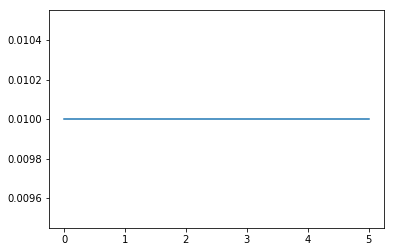

In [23]:
plt.plot(lrs)

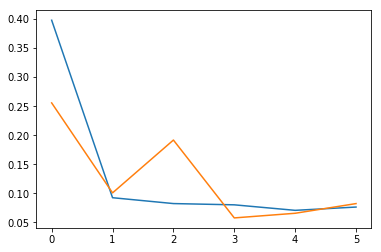

In [24]:
plt.plot(train_losses)
plt.plot(test_losses)

In [25]:
torch.save(best_weights, 'best_weights.pth')
model = StockPredictor(config, cat_dict).to(device)
model.load_state_dict(torch.load('best_weights.pth'))
model.eval()

StockPredictor(
  (emb_drop): Dropout(p=0.05)
  (cat_layers): ModuleList(
    (0): Embedding(31, 31)
    (1): Embedding(5, 5)
    (2): Embedding(366, 50)
    (3): Embedding(4, 4)
    (4): Embedding(2, 2)
    (5): Embedding(2, 2)
    (6): Embedding(2, 2)
    (7): Embedding(2, 2)
    (8): Embedding(2, 2)
    (9): Embedding(2, 2)
  )
  (rnn_layers): LSTM(6, 1000, batch_first=True)
  (fc_layers): Sequential(
    (0): Linear(in_features=60102, out_features=1000, bias=True)
    (1): ReLU(inplace)
    (2): BatchNorm1d(1000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.5)
    (4): Linear(in_features=1000, out_features=500, bias=True)
    (5): ReLU(inplace)
    (6): BatchNorm1d(500, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.25)
  )
  (out): Linear(in_features=500, out_features=1, bias=True)
)

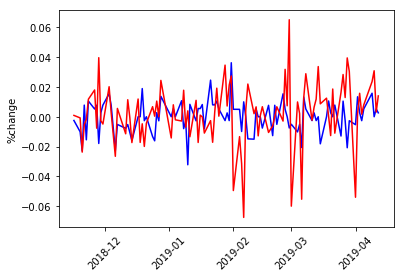

In [26]:
seq_input,cat_input,target = next(iter(test_dl))

# model output
pred_pct = model(seq_input,cat_input)
inv_pred_pct = pred_pct*(max_dict['pct_change']-min_dict['pct_change'])+min_dict['pct_change']
inv_true_pct = target*(max_dict['pct_change']-min_dict['pct_change'])+min_dict['pct_change']
date_test = date_all[split:]

_=plt.plot(date_test[-100:],inv_true_pct.cpu().detach().numpy()[-100:],'b')
_=plt.plot(date_test[-100:],inv_pred_pct.cpu().detach().numpy()[-100:],'r')
_=plt.xticks(rotation=45)
_=plt.ylabel('%change')

In [0]:
# convert to price plot
seq_input,cat_input,target = next(iter(test_dl))

# model output
pred_pct = model(seq_input,cat_input)
inv_pred_pct = pred_pct*(max_dict['pct_change']-min_dict['pct_change'])+min_dict['pct_change']
# to get real price is to multiply the predicted % with previous day close price
prev_day_close = seq_input[:,-1,-2]*(max_dict['Adj Close']-min_dict['Adj Close'])+min_dict['Adj Close']
pred_price = (1+inv_pred_pct.view(-1,))*prev_day_close

inv_true_pct = target*(max_dict['pct_change']-min_dict['pct_change'])+min_dict['pct_change']
true_price = (1+inv_true_pct.view(-1,))*prev_day_close

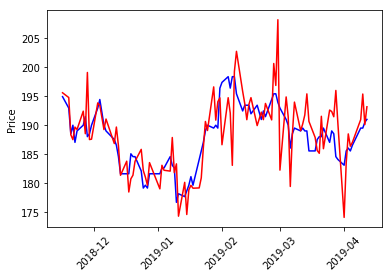

In [28]:
_=plt.plot(date_test[-100:],true_price.cpu().detach().numpy()[-100:],'b')
_=plt.plot(date_test[-100:],pred_price.cpu().detach().numpy()[-100:],'r')
_=plt.xticks(rotation=45)
_=plt.ylabel('Price')

In [29]:
np.corrcoef(true_price.cpu().detach().numpy(),pred_price.cpu().detach().numpy())[0][1]

0.9386470856381617

# **Simulation**

In [30]:
cash = 1_000_000
port = 0
for pct_pred, pct_true in zip(inv_pred_pct.cpu().detach().numpy(),inv_true_pct.cpu().detach().numpy()):
  if pct_pred>0:
    #buy
    if port == 0:
      port=cash
      cash=0
  else:
    #sell
    if port != 0:
      cash=port
      port=0
  #realize
  if port != 0:
    port *= (1+pct_true)
  
equity = cash+port
print(equity)

[1114072.52235364]
